### IMPORTS

In [1]:
from __future__ import annotations

# ============ Standard/Utility ============
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
from collections import Counter
from functools import partial
import yfinance as yf

import numpy as np
import numpy.linalg as la
import pandas as pd
import pandas_ta as ta
import nolds

# ============ ML ============
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    log_loss, average_precision_score, roc_auc_score,
    precision_recall_fscore_support
)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

### FEATURE GENERATION

In [2]:
class PCA_RSI:
    """
    PCA on RSI lookbacks + supervised OLS on forward cumulative log-returns.
    - train(data, label='Close'): fit PCA (train-only) and OLS: fwd log-ret ~ PCs (train-only)
    - transform(data, label='Close'): return a single column DataFrame 'rsi_pca_pred' over data.index
    - predict(data, label='Close'): same as transform but returns a Series
    """

    def __init__(self, rsi_lbs: List[int], n_components: int = 4, standardize: bool = True, horizon: int = 10):
        self.rsi_lbs = sorted(list(rsi_lbs))
        self.n_components = int(n_components)
        self.standardize = bool(standardize)
        self.horizon = int(horizon)

        # learned on train()
        self.cols_: Optional[List[str]] = None
        self.means_: Optional[pd.Series] = None
        self.stds_: Optional[pd.Series] = None
        self.loadings_: Optional[np.ndarray] = None  # (p, k)

        # OLS params (supervised)
        self.coefs_: Optional[np.ndarray] = None     # (k,)
        self.intercept_: Optional[float] = None

    def _rsis(self, close: pd.Series) -> pd.DataFrame:
        return pd.DataFrame({lb: ta.rsi(close, lb) for lb in self.rsi_lbs}, index=close.index)
    
    def _build_rsi_basis(self, data: pd.DataFrame, label: str = "Close") -> pd.DataFrame:
        close = pd.to_numeric(data[label], errors="coerce")
        rsis = pd.DataFrame({lb: ta.rsi(close, lb) for lb in self.rsi_lbs}, index=close.index)
        return rsis

    def train(self, data: pd.DataFrame, label: str = 'Close'):
        close = pd.to_numeric(data[label], errors='coerce')
        rsis = self._rsis(close)
        X = _coerce_float_df(rsis).dropna()     
        if X.empty:
            self.cols_ = self.means_ = self.stds_ = self.loadings_ = None
            self.coefs_ = self.intercept_ = None
            return self

        self.cols_ = list(X.columns)
        self.means_ = X.mean()
        if self.standardize:
            self.stds_ = X.std(ddof=1).replace(0.0, np.nan)
            Z = (X - self.means_) / (self.stds_ + 1e-12)
        else:
            self.stds_ = None
            Z = X - self.means_

        Xz = np.asarray(Z.values, dtype=np.float64)
        U, S, Vt = la.svd(Xz, full_matrices=False)
        self.loadings_ = Vt.T[:, :self.n_components]

        r = np.log(close).diff()
        y_full = r.rolling(self.horizon).sum().shift(-self.horizon)
        y_train = y_full.loc[Z.index]
        mask = y_train.notna()
        if not mask.any():
            self.coefs_ = None
            self.intercept_ = None
            return self

        train_scores = pd.DataFrame(
            Xz @ self.loadings_, index=Z.index,
            columns=[f"rsi_pc{j+1}" for j in range(self.loadings_.shape[1])]
        ).loc[mask]

        y_fit = y_train.loc[mask].values
        A = np.column_stack([np.ones(len(train_scores)), train_scores.values])
        beta = la.lstsq(A, y_fit, rcond=None)[0]
        self.intercept_ = float(beta[0])
        self.coefs_ = beta[1:].astype(float)
        return self

    def transform(self, data: pd.DataFrame, label: str = 'Close', pred_name: str = "rsi_pca_pred") -> pd.DataFrame:
        """Return a single supervised feature column over data.index."""
        if self.loadings_ is None or self.coefs_ is None or self.intercept_ is None or self.cols_ is None:
            return pd.Series(np.nan, index=data.index, name=pred_name).to_frame()

        close = pd.to_numeric(data[label], errors='coerce')
        rsis = self._rsis(close)
        Z = rsis.reindex(columns=self.cols_).copy()          
        Z = _coerce_float_df(Z)
        Z = Z - self.means_
        if self.standardize:
            Z = Z / (self.stds_ + 1e-12)

        mask = Z.notna().all(axis=1)
        out = pd.Series(np.nan, index=rsis.index, name=pred_name)
        if mask.any():
            Xz = np.asarray(Z.loc[mask].values, dtype=np.float64)
            scores = Xz @ self.loadings_
            y_hat = self.intercept_ + (scores @ self.coefs_)
            out.loc[mask] = y_hat
        return out.to_frame()


In [3]:
class PCA_PriceSlope:
    """
    PCA on rolling slopes over multiple lookbacks + supervised regression on forward cumulative log-returns.
    basis: "price" (slope of log-price) or "sma" (slope of SMA(log-price)).
    """

    def __init__(self,
                 slope_lbs: List[int],
                 n_components: int = 3,
                 standardize: bool = True,
                 horizon: int = 10,
                 use_log: bool = True,
                 reg: str = "ols",
                 alpha: float = 1e-3,
                 basis: str = "price",            
                 slope_window: Optional[int] = None  
                 ):
        self.slope_lbs = sorted(list(slope_lbs))
        self.n_components = int(n_components)
        self.standardize = bool(standardize)
        self.horizon = int(horizon)
        self.use_log = bool(use_log)
        self.reg = str(reg).lower()
        self.alpha = float(alpha)
        self.basis = basis.lower()            
        self.slope_window = slope_window      

        # learned on train()
        self.cols_: Optional[List[str]] = None
        self.means_: Optional[pd.Series] = None
        self.stds_: Optional[pd.Series] = None
        self.loadings_: Optional[np.ndarray] = None
        self.coefs_: Optional[np.ndarray] = None
        self.intercept_: Optional[float] = None

            
    def _build_slope_basis(self, data: pd.DataFrame, label: str = "Close") -> pd.DataFrame:
        close = pd.to_numeric(data[label], errors="coerce")
        return self._slopes(close)  # uses your existing _slopes(...)

    @staticmethod
    def _rolling_linreg_slope(x: pd.Series, window: int) -> pd.Series:
        n = window
        t = np.arange(n)
        t_demean = t - t.mean()
        denom = float((t_demean**2).sum())
        def _slope(arr):
            x_demean = arr - arr.mean()
            return (t_demean @ x_demean) / denom
        return x.rolling(n, min_periods=n).apply(_slope, raw=True)

    def _slopes(self, close: pd.Series) -> pd.DataFrame:
        # base series (log-price by default for scale-free slopes)
        base = np.log(close) if self.use_log else close

        out = {}
        if self.basis == "price":  
            for lb in self.slope_lbs:
                out[lb] = self._rolling_linreg_slope(base, lb)
        elif self.basis == "sma":  
            for lb in self.slope_lbs:
                sma = base.rolling(lb, min_periods=lb).mean()
                win = self.slope_window or lb  
                out[lb] = self._rolling_linreg_slope(sma, win)
        else:
            raise ValueError("basis must be 'price' or 'sma'")

        return pd.DataFrame(out, index=close.index)

    def train(self, data: pd.DataFrame, label: str = 'Close'):
        close = pd.to_numeric(data[label], errors='coerce')

        slopes = self._slopes(close)
        X = _coerce_float_df(slopes).dropna()
        if X.empty:
            self.cols_ = self.means_ = self.stds_ = self.loadings_ = None
            self.coefs_ = self.intercept_ = None
            return self

        self.cols_ = list(X.columns)
        self.means_ = X.mean()
        if self.standardize:
            self.stds_ = X.std(ddof=1).replace(0.0, np.nan)
            Z = (X - self.means_) / (self.stds_ + 1e-12)
        else:
            self.stds_ = None
            Z = X - self.means_

        Xz = np.asarray(Z.values, dtype=np.float64)
        U, S, Vt = la.svd(Xz, full_matrices=False)
        self.loadings_ = Vt.T[:, :self.n_components]

        r = np.log(close).diff()
        y_full = r.rolling(self.horizon).sum().shift(-self.horizon)
        y_train = y_full.loc[Z.index]
        mask = y_train.notna()
        if not mask.any():
            self.coefs_ = None
            self.intercept_ = None
            return self

        train_scores = pd.DataFrame(
            Xz @ self.loadings_, index=Z.index,
            columns=[f"slope_pc{j+1}" for j in range(self.loadings_.shape[1])]
        ).loc[mask]

        y_fit = y_train.loc[mask].values
        A = np.column_stack([np.ones(len(train_scores)), train_scores.values])
        beta = la.lstsq(A, y_fit, rcond=None)[0]
        self.intercept_ = float(beta[0])
        self.coefs_ = beta[1:].astype(float)
        return self


    def transform(self, data: pd.DataFrame, label: str = 'Close', pred_name: str = "slope_pca_pred") -> pd.DataFrame:
        if self.loadings_ is None or self.coefs_ is None or self.intercept_ is None or self.cols_ is None:
            return pd.Series(np.nan, index=data.index, name=pred_name).to_frame()

        close = pd.to_numeric(data[label], errors='coerce')
        slopes = self._slopes(close)
        Z = slopes.reindex(columns=self.cols_).copy()
        Z = _coerce_float_df(Z)
        Z = Z - self.means_
        if self.standardize:
            Z = Z / (self.stds_ + 1e-12)

        mask = Z.notna().all(axis=1)
        out = pd.Series(np.nan, index=slopes.index, name=pred_name)
        if mask.any():
            Xz = np.asarray(Z.loc[mask].values, dtype=np.float64)
            scores = Xz @ self.loadings_
            y_hat = self.intercept_ + (scores @ self.coefs_)
            out.loc[mask] = y_hat
        return out.to_frame()



    def predict(self, data: pd.DataFrame, label: str = 'Close') -> pd.Series:
        return self.transform(data, label=label).iloc[:, 0]


In [4]:
################# HELPERS  ##################
import numpy as np
import pandas as pd
import warnings
import nolds

# OLS slope of x on time index over a rolling window (slope per bar).
def rolling_linreg_slope(x: pd.Series, window: int) -> pd.Series:
    n = window
    t = np.arange(n)
    t_mean = t.mean()
    t_demean = t - t_mean
    denom = (t_demean**2).sum()

    def _slope(arr):
        x_demean = arr - arr.mean()
        return (t_demean @ x_demean) / denom

    return x.rolling(n, min_periods=n).apply(_slope, raw=True)


def rolling_zscore(s: pd.Series, w: int) -> pd.Series:
    m = s.rolling(w, min_periods=w).mean()
    sd = s.rolling(w, min_periods=w).std()
    return (s - m) / (sd + 1e-12)


def _coerce_float_df(df: pd.DataFrame) -> pd.DataFrame:
    """Force numeric float64; non-numeric → NaN."""
    out = df.apply(pd.to_numeric, errors="coerce")
    if not np.issubdtype(out.values.dtype, np.floating):
        out = out.astype(np.float64)
    return out

def _softplus_stable(x: np.ndarray | pd.Series) -> np.ndarray | pd.Series:
    x = np.asarray(x)
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0.0)


def softrelu(x: pd.Series) -> pd.Series:
    # softplus shifted so softrelu(0)=0
    _LOG2 = np.log(2.0)
    return pd.Series(_softplus_stable(x) - _LOG2, index=x.index)


################# HURST ##############
def hurst(timeseries, window=30):
    if len(timeseries) < window:
        return np.nan
    return nolds.dfa(np.diff(timeseries))


def calculate_rolling_hurst_pandas(df, price_column='Close', window=30):
    df_result = df.copy()
    df_result['hurst'] = df[price_column].rolling(
        window=window, min_periods=window
    ).apply(lambda x: hurst(x.values), raw=False)
    return df_result

################# MACD ##############
def macd(price: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):
    ema_fast = price.ewm(span=fast, adjust=False).mean()
    ema_slow = price.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    return histogram


################# RETURNS BASED ##############
def log_returns(price):
    return np.log(price).diff()


################# VOLATILITY ##############
def ewm_vol_n(returns, n):
    return returns.ewm(span=n, adjust=False).std(bias=False)


def garman_klass_vol(ohlc: pd.DataFrame, window: int, annualize: bool = False) -> pd.Series:
    """Garman–Klass volatility estimator on daily OHLC bars."""
    eps, trading_days = 1e-12, 252
    H = ohlc["High"].astype(float).clip(lower=eps)
    L = ohlc["Low"].astype(float).clip(lower=eps)
    O = ohlc["Open"].astype(float).clip(lower=eps)
    C = ohlc["Close"].astype(float).clip(lower=eps)
    log_hl = np.log(H / L)
    log_co = np.log(C / O)
    var = (0.5 * (log_hl ** 2) - (2.0 * np.log(2.0) - 1.0) * (log_co ** 2)).rolling(
        window=window, min_periods=window
    ).mean()
    vol = np.sqrt(var.clip(lower=0))
    if annualize:
        vol = vol * np.sqrt(trading_days)
    return vol


################# PRICE BASED #############
def sma(price: pd.Series, n: int):
    return price.rolling(n).mean()


def rsi(price: pd.Series, n: int = 14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))


def price_to_sma_dist(price: pd.Series, n: int) -> pd.Series:
    m = sma(price, n)
    return price / (m + 1e-12) - 1.0


def sma_ratio(price: pd.Series, fast: int, slow: int) -> pd.Series:
    f = sma(price, fast)
    s = sma(price, slow)
    return f / (s + 1e-12) - 1.0


################# COMPOSITE FEATURES ##############
def compute_obv_lr_slope(ohlcv: pd.DataFrame, window: int = 252) -> pd.Series:
    """
    OBV = cumulative signed volume; feature = OLS slope of OBV over 'window'.
    """
    if "Close" not in ohlcv.columns or "Volume" not in ohlcv.columns:
        return pd.Series(index=ohlcv.index, dtype=float, name=f"obv_lr_slope_{window}")
    close = ohlcv["Close"].astype(float)
    vol   = ohlcv["Volume"].astype(float)
    sign  = np.sign(close.diff()).fillna(0.0)
    obv   = (sign * vol).cumsum()
    sl    = rolling_linreg_slope(obv, window)
    return sl.rename(f"obv_lr_slope_{window}")


def Torque_soft1mRSI_posSlopeZ(close: pd.Series,
                               rsi_n: int = 14,
                               slope_w: int = 66,
                               z_w: int = 126) -> pd.Series:
    """
    (1 - RSI/100) * positive(z-score of log-price slope over slope_w), z scored over z_w
    """
    rsi_series = rsi(close, n=rsi_n)
    slope      = rolling_linreg_slope(np.log(close), slope_w)
    slope_z    = rolling_zscore(slope, z_w).clip(lower=0)
    out = (1.0 - rsi_series/100.0) * slope_z
    return out.rename("Torque_soft1mRSI_posSlopeZ")


def HxRSI_softExcessH_soft1mRSI(close: pd.Series,
                                rsi_n: int = 14,
                                hurst_w: int = 252,
                                beta_H: float = 4.0) -> pd.Series:
    """
    softrelu(beta_H*(H-0.5)) * (1 - RSI/100), H = rolling DFA Hurst on price
    """
    warnings.filterwarnings("ignore")
    _tmp = calculate_rolling_hurst_pandas(
        pd.DataFrame({"Close": close}), price_column="Close", window=max(30, hurst_w)
    )
    H = _tmp["hurst"].reindex(close.index)
    soft_excess_H = softrelu(beta_H * (H - 0.5))
    rsi_series = rsi(close, n=rsi_n)
    out = soft_excess_H * (1.0 - rsi_series/100.0)
    return out.rename("HxRSI_softExcessH_soft1mRSI")


################# FEATURE GENERATION ##############
def feature_generation(ohlcv, price_point='Close',
                       h=10,
                       vol_span=20,
                       gk_win: int = 15):

    output = pd.DataFrame(index=ohlcv.index)
    price = ohlcv[price_point].astype(float)

    # returns & vol
    r1 = log_returns(price)
    sigma1 = ewm_vol_n(r1, vol_span)
    output['ewm_vol_20'] = sigma1
    output['gk_vol_15']  = garman_klass_vol(ohlcv, gk_win, annualize=False)

    # Donchian position @ 20 bars
    w = 20
    hh = price.rolling(w, min_periods=w).max()
    ll = price.rolling(w, min_periods=w).min()
    width = (hh - ll).replace(0, np.nan)
    output["donch_pos_20"] = (price - ll) / width

    # volume regime per unit risk
    if "Volume" in ohlcv.columns:
        v = ohlcv["Volume"].astype(float)
        v_ewm = v.ewm(span=vol_span, adjust=False, min_periods=5).mean()
        v_base = v_ewm.rolling(50, min_periods=20).mean()
        v_norm = (v_ewm / (v_base + 1e-12))
        output["vol_over_sigma"] = v_norm * (1.0 / (sigma1 + 1e-12))
    else:
        output["vol_over_sigma"] = np.nan

    # slow-trend displacement @ 100 bars
    output["px_smaSlow_dist_100"] = price_to_sma_dist(price, 100)
    
    # MACD
    output["macd_hist"] = macd(price)

    output.replace([np.inf, -np.inf], np.nan, inplace=True)
    return output

In [5]:
def build_features(ohlcv, train_start, val_start, test_start, test_end, fwd):
    # Base rolling features (8 features - all keepers)
    rolling_features = feature_generation(
        ohlcv[train_start:test_end], price_point='Close', h=fwd, vol_span=20, gk_win=15
    )

    # ===== PCA on RSI =====
    pca_rsi = PCA_RSI(list(range(2, 21)), n_components=3, standardize=True, horizon=fwd)
    pca_rsi.train(ohlcv[train_start:val_start])
    rsi_df = pca_rsi.transform(ohlcv[train_start:test_end], pred_name="rsi_pca_pred")
    rsi_pred = (rsi_df["rsi_pca_pred"] if "rsi_pca_pred" in rsi_df.columns 
                else rsi_df.iloc[:, 0]).rename("rsi_pca_pred") if isinstance(rsi_df, pd.DataFrame) else rsi_df.rename("rsi_pca_pred")

    # ===== PCA on slopes: PRICE basis =====
    pca_price_slope = PCA_PriceSlope(
        slope_lbs=list(range(2, 100)),
        n_components=3, standardize=True, horizon=fwd, basis='price'
    )
    pca_price_slope.train(ohlcv[train_start:val_start])
    ps_df = pca_price_slope.transform(ohlcv[train_start:test_end], pred_name="price_slope_pca_pred")
    price_slope_pred = (ps_df["price_slope_pca_pred"] if "price_slope_pca_pred" in ps_df.columns 
                        else ps_df.iloc[:, 0]).rename("price_slope_pca_pred") if isinstance(ps_df, pd.DataFrame) else ps_df.rename("price_slope_pca_pred")

    # ===== Composites + OBV slope + SMA ratio =====
    close_full = ohlcv.loc[train_start:test_end, "Close"].astype(float)
    torque = Torque_soft1mRSI_posSlopeZ(close_full, rsi_n=14, slope_w=66, z_w=126)
    hx = HxRSI_softExcessH_soft1mRSI(close_full, rsi_n=14, hurst_w=252, beta_H=4.0)
    obv_slope = compute_obv_lr_slope(ohlcv.loc[train_start:test_end], window=252)
    sma_ratio_5_252 = sma_ratio(close_full, 5, 252).rename("sma_ratio_5_252")

    # Concatenate (14 features total)
    features = pd.concat([torque, hx,price_slope_pred, rsi_pred,obv_slope, 
                          sma_ratio_5_252,rolling_features], axis=1)
    
    #features = pd.concat([rolling_features, torque, hx, obv_slope,sma_ratio_5_252], axis=1)
    
    
    # Split matrices
    x_train = features[train_start:val_start]
    x_val = features[val_start:test_start]
    x_test = features[test_start:test_end]
    
    return x_train, x_val, x_test
    
    
def build_target(ohlcv, train_start, val_start, test_start, test_end, fwd, k=0.5):
    
    def ewm_volatility(returns: pd.Series, halflife: int = 20, min_periods: int | None = None) -> pd.Series:
        if min_periods is None:
            min_periods = max(5, int(np.ceil(halflife)))
        return returns.ewm(halflife=halflife, adjust=False, min_periods=min_periods).std()
    
    def log_returns(price: pd.Series) -> pd.Series:
        return np.log(price).diff()
    
    def fwd_cum_returns(returns: pd.Series, n: int) -> pd.Series:
        return returns.rolling(n).sum().shift(-n)
    
    def choose_k_by_trade_rate(fwd_h: pd.Series, sigma_1: pd.Series, h: int, train_mask: pd.Series,
                           target_trade_frac: float = 0.40, sqrt_h: bool = True) -> float: # tried .3
 
        scale = np.sqrt(h) if sqrt_h else 1.0
        z = (fwd_h / (sigma_1 * scale)).abs()
        z_train = z[train_mask].dropna()
        if len(z_train) == 0:
            return 0.5  
        return float(z_train.quantile(1.0 - target_trade_frac))
    
    price_point = 'Close'
    vol_halflife = 20 # THINK ABOUT THIS ONE
    sqrt_h = True
    #k = 0.5
    auto_k_trade_frac = None
    
    returns = log_returns(ohlcv.loc[train_start:test_end, price_point])
    fwd_h = fwd_cum_returns(returns, fwd)  

    sigma_1 = ewm_volatility(returns, halflife=vol_halflife)  
    scale = np.sqrt(fwd) if sqrt_h else 1.0

    if auto_k_trade_frac is not None:
        train_mask = (ohlcv.index >= pd.to_datetime(train_start)) & (ohlcv.index < pd.to_datetime(val_start))
        k = choose_k_by_trade_rate(fwd_h, sigma_1, fwd, train_mask, target_trade_frac=auto_k_trade_frac, sqrt_h=sqrt_h)

    tau_t = k * sigma_1 * scale
    #print(tau_t)
    #tau_t = pd.Series(0.02, index=fwd_h.index)
    
    lbl = pd.Series(pd.NA, index=ohlcv[train_start:test_end].index, dtype='Int8')
    valid = (~fwd_h.isna()) & (~tau_t.isna())
    
    lbl.loc[valid & (fwd_h < -tau_t)] = 0
    lbl.loc[valid & (fwd_h >= -tau_t) & (fwd_h < tau_t)] = 1
    lbl.loc[valid & (fwd_h >  tau_t)] =  2
    
    y_train, y_val, y_test = lbl[train_start:val_start], lbl[val_start:test_start], lbl[test_start:test_end]
    
    return y_train, y_val, y_test

def data_builder(ohlcv, train_start, val_start, test_start, test_end, fwd, k=0.5):
    
    x_train, x_val, x_test = build_features(ohlcv, train_start, val_start, test_start, test_end, fwd)
    y_train, y_val, y_test = build_target(ohlcv, train_start, val_start, test_start, test_end, fwd, k)
    
    def align_features_targets(X, y):
        X = X.dropna()
        y = y.loc[X.index]
        y = y.dropna()
        X = X.loc[y.index]
        return X, y
    
    x_train, y_train = align_features_targets(x_train, y_train)
    x_val, y_val = align_features_targets(x_val, y_val)
    x_test, y_test = align_features_targets(x_test, y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test

### MODEL BUILDING

In [6]:
def check_min_prevalence(y, min_count=1, min_pct=0.10, classes=(0, 1, 2)):
    """Check if all classes meet minimum count and percentage thresholds."""
    counts = pd.Series(y).astype(int).value_counts()
    n_total = len(y)
    
    for cls in classes:
        count = counts.get(cls, 0)
        if count < min_count or count / n_total < min_pct:
            return False
    
    return True

def hopt_space():
    """Define hyperparameter search space."""
    return {
        "max_depth": hp.quniform("max_depth", 2, 4, 1),
        "min_child_weight": hp.loguniform("min_child_weight", np.log(3.0), np.log(12.0)),
        "gamma": hp.uniform("gamma", 0.0, 5.0),
        "subsample": hp.uniform("subsample", 0.5, 0.9),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.9),
        "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(1.0)),
        "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-2), np.log(20.0)),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.03), np.log(0.20)),
    }

def coerce_params(p):
    """Coerce hyperparameters to correct types."""
    p = dict(p)
    p["max_depth"] = int(p["max_depth"])
    return p

def tune_xgb_hyperopt(Xtr, ytr, Xva, yva, sw_tr, 
                     n_estimators=2000,
                     early_stopping_rounds=250,
                     random_state=42,
                     tune_trials=250):
    
    space = hopt_space()
    trials = Trials()
    rng = np.random.default_rng(random_state)
    
    def objective(sample):
        params = coerce_params(sample)
        model = XGBClassifier(
            objective="multi:softprob", num_class=3, tree_method="hist",
            n_jobs=-1, eval_metric="mlogloss",
            early_stopping_rounds=early_stopping_rounds, 
            n_estimators=n_estimators,
            random_state=random_state,
            **params
        )
        
        model.fit(Xtr, ytr.values, sample_weight=sw_tr,
                 eval_set=[(Xva,yva.values)], verbose=False)
        
        proba_va = model.predict_proba(Xva, iteration_range=(0, model.best_iteration+1))
        Yb_va = label_binarize(yva, classes=[0,1,2])
        pr_macro = average_precision_score(Yb_va, proba_va, average="macro")
        
        return {"loss":1.0 - pr_macro, "status": STATUS_OK}
    
    best = fmin(
    fn=objective,
    space=space,
    algo=partial(tpe.suggest, n_startup_jobs=15),
    max_evals=tune_trials,
    rstate=rng,
    trials=trials,
    show_progressbar=True
    )
    print(coerce_params(best))
    return coerce_params(best)

In [7]:
def train_smallN_xgb(Xtr, ytr, Xva, yva,
                     n_estimators=2000,
                     random_state=42,
                     n_jobs=-1
                     ):
    ytr = pd.Series(ytr).astype("int64")
    yva = pd.Series(yva).astype("int64")
    
    if not check_min_prevalence(yva, min_count=3, min_pct=0.1):
        return {"skipped": True}
    
    #sw_tr = compute_sample_weight(class_weight="balanced", y=ytr.values)
    
    train_dates = Xtr.index
    days_from_end = (train_dates[-1] - train_dates).days
    time_weights = np.exp(-days_from_end / 250) 
    sw_tr = compute_sample_weight(class_weight="balanced", y=ytr.values) * time_weights
    
    tuned_params = tune_xgb_hyperopt(Xtr, ytr, Xva, yva, sw_tr)
    
    base_kwargs = {
        "objective": "multi:softprob", 
        "num_class": 3, 
        "tree_method": "hist",
        "n_estimators": n_estimators, 
        "random_state": random_state, 
        "n_jobs": n_jobs,
        "eval_metric": "mlogloss",
        "early_stopping_rounds":40
    }
    
    final_kwargs = base_kwargs | tuned_params
    
    
    xgb = XGBClassifier(**final_kwargs)
    xgb.fit(Xtr, ytr.values, sample_weight=sw_tr,
           eval_set=[(Xva, yva.values)], verbose=False)
    
    #proba_va = xgb.predict_proba(Xva, iteration_range=(0, model.best_iteration+1))
    #ypred_va = proba_va.argmax(axis=1)
    #Yb_va = label_binarize(yva, classes=[0,1,2])

    unique, counts = np.unique(ytr.values, return_counts=True)
    class_proportions = counts / len(ytr)
    baseline_macro = np.mean(class_proportions)
    
    feature_importance = pd.Series(xgb.feature_importances_, index=Xtr.columns).sort_values(ascending=False)

    return {"skipped":False,
            "model": xgb,
            "baseline_macro": baseline_macro,
            "feature_importance": feature_importance}

In [8]:
def evaluate_model(train_dict, Xte, yte):
    if train_dict["skipped"]==True:
        return train_dict
    
    model = train_dict["model"]
    yte = pd.Series(yte).astype("int64")
    proba = model.predict_proba(Xte, iteration_range=(0, model.best_iteration+1))
    Yb = label_binarize(yte, classes=[0,1,2])
    
    train_dict["proba"] = pd.DataFrame(
        proba, 
        index=Xte.index,
        columns=["p_class0", "p_class1", "p_class2"]
    )
    train_dict["pr_macro"] = average_precision_score(Yb, proba, average="macro")
    # could consider including yte here for diagnostics later...
    return train_dict
    

In [9]:
def canonicalize_ohlcv(df: pd.DataFrame, ticker: str = None) -> pd.DataFrame:
    """Normalize yfinance OHLCV data to single-index with standard columns."""
    df.columns = df.columns.droplevel('Ticker')
    return df

In [10]:
def simple_threshold_trader(proba_df: pd.DataFrame, ohlcv: pd.DataFrame,
                           enter_threshold: float = 0.15,
                           exit_threshold: float = 0.05,
                           fee_bps: float = 5.0) -> Tuple[pd.Series, pd.Series, pd.DataFrame]:
    """
    Simple threshold-based trader using model probabilities.
    
    Args:
        proba_df: DataFrame with columns p_class0, p_class1, p_class2
        ohlcv: Price data with 'Close' column
        enter_threshold: Enter trade when |signal| > this
        exit_threshold: Exit when |signal| < this
        fee_bps: Transaction cost in basis points
        
    Returns:
        (pnl_series, position_series, trades_df)
    """
    price = ohlcv['Close'].reindex(proba_df.index).ffill()
    
    # Signal = prob(up) - prob(down), ranges from -1 to +1
    signal = proba_df['p_class2'] - proba_df['p_class0']
    
    # Initialize
    position = pd.Series(0.0, index=signal.index)
    pnl = pd.Series(0.0, index=signal.index)
    cash = 0.0
    current_pos = 0.0
    trades = []
    
    for i, ts in enumerate(signal.index):
        s = signal.loc[ts]
        p = price.loc[ts]
        
        # Determine target position
        if abs(s) > enter_threshold:
            target_pos = np.sign(s)  # +1 for long, -1 for short
        elif abs(s) < exit_threshold:
            target_pos = 0.0
        else:
            target_pos = current_pos  # Hold
        
        # Execute trade if position changes
        if target_pos != current_pos:
            trade_size = target_pos - current_pos
            trade_cost = abs(trade_size) * p
            fee = trade_cost * (fee_bps / 10000)
            
            cash -= trade_size * p + fee
            
            trades.append({
                'date': ts,
                'signal': s,
                'price': p,
                'from_pos': current_pos,
                'to_pos': target_pos,
                'trade_size': trade_size,
                'fee': fee
            })
            
            current_pos = target_pos
        
        position.loc[ts] = current_pos
        pnl.loc[ts] = cash + current_pos * p
    
    trades_df = pd.DataFrame(trades)
    return pnl, position, trades_df


def evaluate_trading_performance(pnl: pd.Series, position: pd.Series, 
                                 price: pd.Series) -> Dict[str, float]:
    """Calculate trading performance metrics."""
    
    # Equity curve (normalized to start at 1.0)
    equity = 1.0 + (pnl / price.iloc[0])
    
    # Returns
    daily_ret = equity.pct_change().dropna()
    total_return = equity.iloc[-1] - 1.0
    
    # Risk metrics
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0.0
    max_dd = (equity / equity.cummax() - 1.0).min()
    
    # Trading metrics
    turnover = position.diff().abs().sum()
    pct_in_market = (position != 0).sum() / len(position)
    
    return {
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'annualized_vol': daily_ret.std() * np.sqrt(252),
        'turnover': turnover,
        'pct_in_market': pct_in_market,
        'final_equity': equity.iloc[-1]
    }


In [11]:
def run_backtest_experiment(tickers: List[str], 
                           train_start: str,
                           val_start: str, 
                           test_start: str,
                           test_end: str,
                           fwd: int = 20,
                           k: float = 0.5,
                           enter_threshold: float = 0.15,
                           exit_threshold: float = 0.05,
                           fee_bps: float = 5.0):
    """
    Run backtesting experiment across multiple tickers.
    
    Returns:
        results_dict with per-ticker results and aggregate statistics
    """
    all_results = []
    
    for i, ticker in enumerate(tickers):
        print(f"\n[{i+1}/{len(tickers)}] Processing {ticker}...")
        
        try:
            # Download data
            ohlcv = yf.download(ticker, start=train_start, end=test_end, 
                               auto_adjust=True, progress=False)
            if ohlcv.empty or len(ohlcv) < 600:
                print(f"  SKIP: Insufficient data")
                continue
                
            ohlcv = canonicalize_ohlcv(ohlcv)
            
            # Build features and train model
            Xtr, Xva, Xte, ytr, yva, yte = data_builder(
                ohlcv, train_start, val_start, test_start, test_end, fwd, k
            )
            
            # Check data quality
            if len(Xtr) < 100 or len(Xva) < 30 or len(Xte) < 40:
                print(f"  SKIP: Insufficient aligned samples")
                continue
            
            # Train model
            model_results = train_smallN_xgb(Xtr, ytr, Xva, yva)
            
            if model_results.get("skipped"):
                print(f"  SKIP: Training failed validation checks")
                continue
            
            # Evaluate on test set
            model_results = evaluate_model(model_results, Xte, yte)
            
            # Check if model actually trained
            if model_results['model'].best_iteration < 5:
                print(f"  SKIP: Model barely trained (iter={model_results['model'].best_iteration})")
                continue
            
            # Trading simulation
            test_ohlcv = ohlcv[test_start:test_end]
            
            pnl, position, trades = simple_threshold_trader(
                proba_df=model_results['proba'],
                ohlcv=test_ohlcv,
                enter_threshold=enter_threshold,
                exit_threshold=exit_threshold,
                fee_bps=fee_bps
            )
            
            strategy_perf = evaluate_trading_performance(
                pnl, position, test_ohlcv['Close']
            )
            
            # Buy & Hold baseline
            bh_price = test_ohlcv['Close']
            bh_equity = bh_price / bh_price.iloc[0]
            bh_returns = bh_equity.pct_change().dropna()
            bh_sharpe = (bh_returns.mean() / bh_returns.std()) * np.sqrt(252) if bh_returns.std() > 0 else 0.0
            bh_total_return = bh_equity.iloc[-1] - 1.0
            bh_max_dd = (bh_equity / bh_equity.cummax() - 1.0).min() 
            
            # Strategy equity curve for plotting
            strategy_equity = 1.0 + (pnl / bh_price.iloc[0])
            strategy_returns = strategy_equity.pct_change().dropna()
          
            all_results.append({
                'ticker': ticker,
                'best_iteration': model_results['model'].best_iteration,
                'pr_macro': model_results['pr_macro'],
                'strategy_sharpe': strategy_perf['sharpe'],
                'strategy_return': strategy_perf['total_return'],
                'strategy_max_dd': strategy_perf['max_drawdown'],
                'strategy_turnover': strategy_perf['turnover'],
                'bh_sharpe': bh_sharpe,
                'bh_return': bh_total_return,
                'bh_max_dd': bh_max_dd,  
                'strategy_equity': strategy_equity,
                'bh_equity': bh_equity,
                'strategy_returns': strategy_returns,
                'bh_returns': bh_returns,
                'num_trades': len(trades)
            })
            
            print(f"  ✓ Strategy Sharpe: {strategy_perf['sharpe']:.2f} | "
                  f"BH Sharpe: {bh_sharpe:.2f} | "
                  f"Trades: {len(trades)}")
            
        except Exception as e:
            print(f"  ERROR: {str(e)}")
            continue
    
    if not all_results:
        print("\nNo valid results!")
        return None
    
    traded_results = [r for r in all_results if r['num_trades'] > 0]
    baseline=0.333
    
        # Calculate statistics only on traded stocks
    pr_macros = [r['pr_macro'] for r in traded_results]
    strategy_sharpes = [r['strategy_sharpe'] for r in traded_results]
    bh_sharpes = [r['bh_sharpe'] for r in traded_results]
    strategy_max_dds = [r['strategy_max_dd'] for r in traded_results]
    bh_max_dds = [r['bh_max_dd'] for r in traded_results]  # Add this line

    print("\n" + "="*60)
    print("AGGREGATE RESULTS")
    print("="*60)
    print(f"Total stocks processed: {len(all_results)}")
    print(f"Stocks with trades: {len(traded_results)}")
    print(f"Stocks skipped (no trades): {len(all_results) - len(traded_results)}")

    print(f"\nModel PR-AUC: {np.mean(pr_macros):.3f} ± {np.std(pr_macros):.3f}")
    print(f"Baseline (random): 0.333")
    print(f"Average lift: {np.mean(pr_macros) - 0.333:.3f}")

    print(f"\nStrategy Sharpe: {np.mean(strategy_sharpes):.3f} ± {np.std(strategy_sharpes):.3f}")
    print(f"Strategy Max DD: {np.mean(strategy_max_dds):.3f} ± {np.std(strategy_max_dds):.3f}")
    print(f"Buy & Hold Sharpe: {np.mean(bh_sharpes):.3f} ± {np.std(bh_sharpes):.3f}")
    print(f"Buy & Hold Max DD: {np.mean(bh_max_dds):.3f} ± {np.std(bh_max_dds):.3f}")  # Add this line
    print(f"Strategy outperforms: {sum(s > b for s, b in zip(strategy_sharpes, bh_sharpes))}/{len(traded_results)} stocks")

    # Plot equity curves
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    colormap = 'hsv' 
    n_stocks = len(all_results)
    colors = plt.cm.get_cmap(colormap)(np.linspace(0, 1, n_stocks))

    # Strategy equity curves
    for idx, r in enumerate(all_results):
        axes[0].plot(r['strategy_equity'].index, r['strategy_equity'].values, 
                    alpha=0.6, linewidth=0.8, color=colors[idx])
    axes[0].set_title(f'Strategy Equity Curves (n={n_stocks})')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Equity (rebased to 1.0)')
    axes[0].grid(alpha=0.3)
    axes[0].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)

    # Buy & Hold equity curves
    for idx, r in enumerate(all_results):
        axes[1].plot(r['bh_equity'].index, r['bh_equity'].values, 
                    alpha=0.6, linewidth=0.8, color=colors[idx])
    axes[1].set_title(f'Buy & Hold Equity Curves (n={n_stocks})')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Equity (rebased to 1.0)')
    axes[1].grid(alpha=0.3)
    axes[1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)

    plt.tight_layout()
    plt.show()
    
    return {
        'results': all_results,
        'traded_results': traded_results,
        'summary': {
            'strategy_sharpe_mean': np.mean(strategy_sharpes),
            'strategy_sharpe_std': np.std(strategy_sharpes),
            'strategy_max_dd_mean': np.mean(strategy_max_dds),
            'strategy_max_dd_std': np.std(strategy_max_dds),
            'bh_sharpe_mean': np.mean(bh_sharpes),
            'bh_sharpe_std': np.std(bh_sharpes),
            'bh_max_dd_mean': np.mean(bh_max_dds), 
            'bh_max_dd_std': np.std(bh_max_dds),   
            'pr_macro_mean': np.mean(pr_macros),
            'pr_macro_std': np.std(pr_macros),
            'n_stocks_total': len(all_results),
            'n_stocks_traded': len(traded_results)
        }
    }


[1/66] Processing AAPL...
  SKIP: Training failed validation checks

[2/66] Processing MSFT...
100%|███████| 250/250 [00:22<00:00, 10.88trial/s, best loss: 0.4194125425795262]
{'colsample_bytree': 0.6503681648020972, 'gamma': 4.515410523512545, 'learning_rate': 0.06731845796519385, 'max_depth': 4, 'min_child_weight': 3.2275808764493257, 'reg_alpha': 0.03301777403970365, 'reg_lambda': 0.38044908235774433, 'subsample': 0.5188520548651818}
  ✓ Strategy Sharpe: 0.00 | BH Sharpe: 1.01 | Trades: 0

[3/66] Processing GOOGL...
100%|██████| 250/250 [00:23<00:00, 10.66trial/s, best loss: 0.46522348009779824]
{'colsample_bytree': 0.8094388840891483, 'gamma': 0.2963650825232811, 'learning_rate': 0.043922843155419326, 'max_depth': 2, 'min_child_weight': 9.137533664577491, 'reg_alpha': 0.0019334627350767598, 'reg_lambda': 13.76588876415547, 'subsample': 0.5003594055477676}
  ✓ Strategy Sharpe: 0.00 | BH Sharpe: 1.35 | Trades: 0

[4/66] Processing GOOG...
100%|████████| 250/250 [00:24<00:00, 10.21tr

100%|██████| 250/250 [00:32<00:00,  7.77trial/s, best loss: 0.20799562889810852]
{'colsample_bytree': 0.6688008489196489, 'gamma': 4.998822948542024, 'learning_rate': 0.05563259240028458, 'max_depth': 4, 'min_child_weight': 9.200670150661702, 'reg_alpha': 0.12502519666381323, 'reg_lambda': 0.24745822518203703, 'subsample': 0.8343335341176983}
  ✓ Strategy Sharpe: 1.04 | BH Sharpe: -0.23 | Trades: 2

[24/66] Processing ADBE...
100%|████████| 250/250 [00:49<00:00,  5.07trial/s, best loss: 0.332703996848969]
{'colsample_bytree': 0.6122426085329747, 'gamma': 2.739492186740038, 'learning_rate': 0.10708607982498633, 'max_depth': 4, 'min_child_weight': 5.414506020667494, 'reg_alpha': 0.8505185680552345, 'reg_lambda': 0.7013537420146679, 'subsample': 0.8048412136050891}
  ✓ Strategy Sharpe: 0.00 | BH Sharpe: -0.90 | Trades: 0

[25/66] Processing INTU...
100%|███████| 250/250 [00:26<00:00,  9.36trial/s, best loss: 0.4648030861830553]
{'colsample_bytree': 0.7282525157062479, 'gamma': 3.204052290

100%|███████| 250/250 [00:34<00:00,  7.32trial/s, best loss: 0.3487525987562945]
{'colsample_bytree': 0.4484088711437555, 'gamma': 4.438553461530949, 'learning_rate': 0.08560493504817301, 'max_depth': 4, 'min_child_weight': 8.51268769052774, 'reg_alpha': 0.00830767693045639, 'reg_lambda': 0.4390092487490951, 'subsample': 0.7239191700553895}
  ✓ Strategy Sharpe: -0.65 | BH Sharpe: -0.85 | Trades: 1

[46/66] Processing ABBV...
100%|██████| 250/250 [00:34<00:00,  7.32trial/s, best loss: 0.34202439175197397]
{'colsample_bytree': 0.8880665877116805, 'gamma': 0.012218941671599481, 'learning_rate': 0.030350761226879276, 'max_depth': 4, 'min_child_weight': 3.655945649013992, 'reg_alpha': 0.0008249218003665522, 'reg_lambda': 10.345283061822284, 'subsample': 0.789553002966011}
  ✓ Strategy Sharpe: 0.30 | BH Sharpe: 0.85 | Trades: 12

[47/66] Processing ABT...
100%|██████| 250/250 [00:31<00:00,  7.89trial/s, best loss: 0.32887494877924517]
{'colsample_bytree': 0.6193861193060322, 'gamma': 2.91116

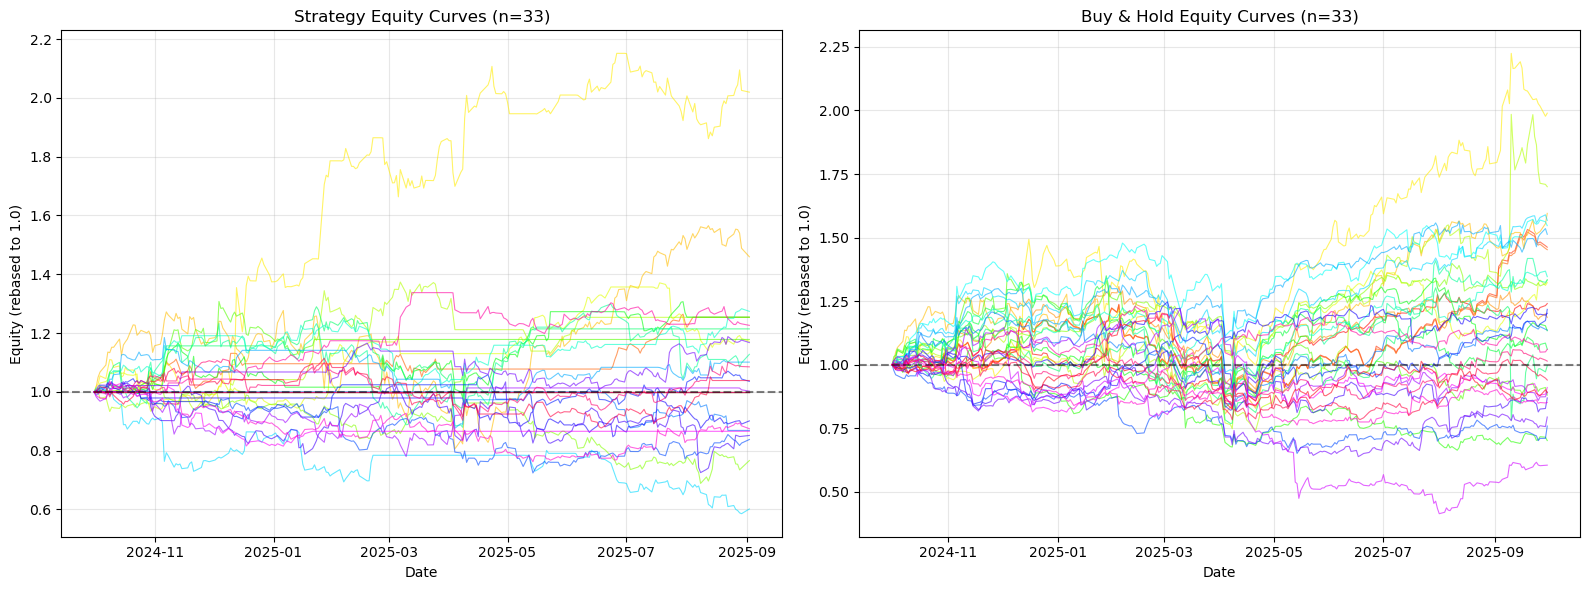

In [ ]:

# Run the experiment
tickers = [
   "AAPL","MSFT","GOOGL","GOOG","AMZN","META","NVDA","TSLA","AMD","INTC",
   "AVGO","QCOM","TXN","ADI","MU","AMAT","LRCX","KLAC","ASML","IBM",
   "ORCL","CSCO","CRM","ADBE","INTU","NOW","SNPS","CDNS",
   "JPM","BAC","WFC","C","GS","MS","AXP","BLK","SCHW","COF","PNC","USB","BK","CME",
   "JNJ","PFE","MRK","ABBV","ABT","LLY","TMO","DHR","MDT","BMY","UNH","AMGN","GILD","ISRG",
   "PG","KO","PEP","WMT","COST","HD","LOW","TGT","MCD","SBUX"] #,"NKE","BKNG","CMG","ORLY","AZO","ULTA",
   #"XOM","CVX","COP","SLB","EOG","OXY","MPC","VLO",
   #"CAT","DE","BA","LMT","NOC","GE","MMM","HON","UPS","FDX","UNP","CSX",
   #"LIN","APD","SHW","FCX",
   #"NEE","DUK","AMT","PLD"
#]

experiment_results = run_backtest_experiment(
    tickers=tickers,
    train_start="2020-04-01",
    val_start="2024-04-01",A machine learning approach to momentum detection in single-stock time series using only autocorrelation features, achieving meaningful classification accuracy with reduced drawdown compared to buy-and-hold strategies.
    test_start="2024-10-01",
    test_end="2025-10-01",
    fwd=20,
    k=0.5,
    enter_threshold=0.15,
    exit_threshold=0.05,
    fee_bps=5.0
)
